<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    FIT-HCMUS, VNU-HCM 
    <br>
    Introduction To Data Science 
    <br>
    Final project 📌
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 04 - Data Modelling 📌
</div>

##  Problem statement


- **Stating problem**: In the realm of professional football, accurately assessing and predicting a player's performance remains a challenging task. Coaches, managers, and scouts often rely on subjective evaluations and historical data, but there is a growing need for a more sophisticated and data-driven approach to player performance prediction. To address this gap, the problem at hand is to develop a robust predictive model that can accurately forecast the performance of a football player based on various factors, including but not limited to fitness levels, historical performance stats, injury history and situational context.
- **Purposes/benefits** of solving the problem:
    - Successful predictive model would revolutionize the player recruitment process, allowing teams to identify talent more efficiently. By evaluating the potential performance of players based on objective data, teams can make more informed decisions in the transfer market, minimizing risks and maximizing the likelihood of acquiring valuable assets.
    - Coaches can leverage the predictive model to tailor their strategies and game plans based on the expected performance of individual players. This can lead to more effective and adaptive team strategies, optimizing player positions, substitutions, and tactical approaches during matches.
    - The model's insights can be used by coaches and sports scientists to design personalized training programs for players. Tailoring training regimens based on predicted performance metrics can contribute to individual player development and overall team improvement.
- **Approach**: In this section, we explore the application of three different models to address this problem, including `Linear Regression`, `Random Forest`, `Neural Network`. A final comparison of the results will be conducted to determine the most suitable model for solving this particular problem.

## Set up enviroment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data preparation

**reading data**

In [2]:
df = pd.read_csv('../../data/processed/encoded_data.csv')
# df = pd.read_csv('../../data/processed/scaled_encoded_data.csv')
df.head()

,Age,LgRank,MP,Starts,Min,90s,Gls,Ast,G+A,G-PK,...,npxG+xAG/90,Injury,Days,Games missed,Position_DF,Position_FW,Position_MF,PreferredFoot_ Both,PreferredFoot_ Left,PreferredFoot_ Right
0,17,4,16,13,1277,14.2,0,0,0,0,...,0.020000,1,128.0,22.0,1,0,0,0,0,1
1,18,17,12,11,992,11.0,0,0,0,0,...,0.030000,1,77.0,19.0,1,0,0,0,0,1
2,19,9,26,26,2326,12.9,1,0,1,1,...,0.088306,0,0.0,0.0,1,0,0,0,0,1
3,19,10,26,26,2326,12.9,1,0,1,1,...,0.088306,0,0.0,0.0,1,0,0,0,0,1
4,20,2,36,36,3240,36.0,0,0,0,0,...,0.060000,0,0.0,0.0,1,0,0,0,0,1


### Preprocess

**Extracting necessary features**

In [3]:
# ----------------------------------Random Forest----------------------------------
X_rf = df.drop(['Gls', 'Ast', 'G+A', 'Gls/90', 'Ast/90', 'G+A/90'], axis=1)
y_rf = df['G+A']

### Spliting train - validation - test set

In [4]:
# ----------------------------------Random Forest----------------------------------
# train-validation-test proportion: 70-15-15
X_rf_train, X_rf_temp, y_rf_train, y_rf_temp = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)
X_rf_validation, X_rf_test, y_rf_validation, y_rf_test = train_test_split(X_rf_temp, y_rf_temp, test_size=0.5, random_state=42)

## Create models

In [5]:
# ----------------------------------Random Forest----------------------------------
# Define the hyperparameter grid
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=10)],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42
)

## Training phase 

### Training models

In [6]:
# ----------------------------------Random Forest----------------------------------
# Fit the RandomizedSearchCV to find the best hyperparameters
random_search.fit(X_rf_train, y_rf_train)

# Get the best hyperparameters
best_params_random = random_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params_random)

best_rf_model = random_search.best_estimator_

Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15}


### Evaluation

In [7]:
y_rf_validation_pred_random = best_rf_model.predict(X_rf_validation)

# Evaluate the model on the validation set
mse_random = mean_squared_error(y_rf_validation, y_rf_validation_pred_random)
mae_random = mean_absolute_error(y_rf_validation, y_rf_validation_pred_random)
r2_random = r2_score(y_rf_validation, y_rf_validation_pred_random)

print('Validation Set Metrics:')
print(f'Mean Squared Error (MSE): {mse_random}')
print(f'Mean Absolute Error (MAE): {mae_random}')
print(f'R^2 Score: {r2_random}')

Validation Set Metrics:
Mean Squared Error (MSE): 4.760829061691066
Mean Absolute Error (MAE): 1.0538291084996663
R^2 Score: 0.942655102929453


## Testing phase 

### Testing models

In [8]:
y_rf_test_pred_random = best_rf_model.predict(X_rf_test)
test_mse_random = mean_squared_error(y_rf_test, y_rf_test_pred_random)
test_mae_random = mean_absolute_error(y_rf_test, y_rf_test_pred_random)
test_r2_random = r2_score(y_rf_test, y_rf_test_pred_random)

print('Test Set Metrics:')
print(f'Mean Squared Error (MSE): {test_mse_random}')
print(f'Mean Absolute Error (MAE): {test_mae_random}')
print(f'R^2 Score: {test_r2_random}')

Test Set Metrics:
Mean Squared Error (MSE): 5.305140435362749
Mean Absolute Error (MAE): 0.9849512542612242
R^2 Score: 0.9475989936311416


**Visualize predicted vs actual output**

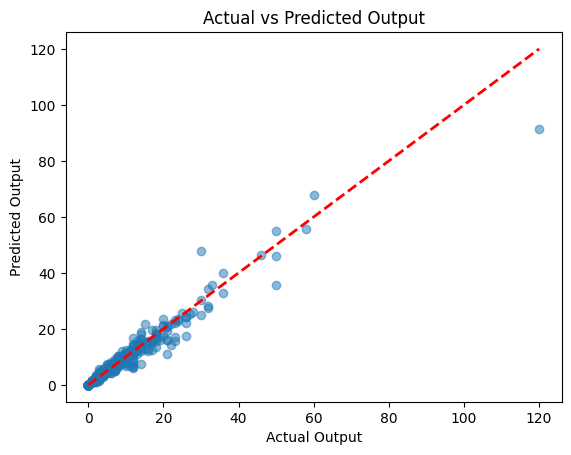

In [12]:
plt.scatter(y_rf_test, y_rf_test_pred_random, alpha=0.5)
plt.title('Actual vs Predicted Output')
plt.xlabel('Actual Output')
plt.ylabel('Predicted Output')

x_line = np.linspace(min(y_rf_test), max(y_rf_test), 100)
plt.plot(x_line, x_line, color='red', linestyle='--', linewidth=2)

plt.show()

## Results analysis - Compare models

In [10]:
# YOUR CODE HERE

## Conclusion